In [31]:
##############################
### Place all imports here ###
##############################
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from elpv_reader import load_dataset_cv2

from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer

# Method 1:

# Method 2:

In this method, we create a CNN model with 3 convolutional layers and 2 fully connected layers. The first convolutional layer has 16 filters, the second has 32 filters and the third has 64 filters. The first fully connected layer has 256 neurons and the second has 4 neurons and inbetween these two fully connected layers, there is a dropout which randomly drops some neurons inorder to counteract overfitting. The activation function used in all the layers is ReLU. The model is trained for 20 epochs with a batch size of 64 for training and 32 for validation and testing.

### Load\Preprocess Data
In this stage, we load the data from the reader file and preprocess it. The preprocessing steps include using Stratified Sampling to split the data into training, validation and testing sets. The training set is used to train the model, the validation set is used to tune the hyperparameters and the testing set is used to test the model. The data is also normalized by dividing it by 255.0 so that the values are between 0 and 1. The data is also shuffled and batched so that the model does not learn the order of the data.

In [2]:
# Load dataset from a new custom function which uses cv2 rather than numpy to load images
# This retains the color channels of the images in the array
images, proba, types = load_dataset_cv2()

In [3]:
# Seperate into training, validation, and testing sets
# Use Stratified Sampling to ensure that the training, validation, and testing sets have the same distribution of classes
# New images can be created by flipping the existing images horizontally and vertically
# This preserves the details necessary for the model to make accurate predictions while also increasing the size of the dataset

unique_proba = np.unique(proba)
unique_types = np.unique(types)

sampled_training_data = []
sampled_training_labels = []

sampled_validation_data = []
sampled_validation_labels = []

sampled_testing_data = []
sampled_testing_labels = []

for label in unique_proba:
    indices = np.where(proba == label)[0]
    
    sample_training_size = int((len(images) * 0.50) * len(indices) / len(images))
    sample_val_test_size = int((len(images) * 0.25) * len(indices) / len(images))
    
    sample_training_indices = np.random.choice(indices, size=sample_training_size, replace = True)
    sample_validation_indices = np.random.choice(indices, size=sample_val_test_size, replace = True)
    sample_testing_indices = np.random.choice(indices, size=sample_val_test_size, replace = True)
    
    sampled_training_data.append(images[sample_training_indices])
    sampled_training_labels.append(proba[sample_training_indices])
    
    sampled_validation_data.append(images[sample_validation_indices])
    sampled_validation_labels.append(proba[sample_validation_indices])
    
    sampled_testing_data.append(images[sample_testing_indices])
    sampled_testing_labels.append(proba[sample_testing_indices])

In [4]:
# Create training set
# Training set is 50% of the dataset
# Validation and testing sets are 25% of the dataset each
# The following code is used to combine the sampled data into the training, validation, and testing sets
# The data is combined into a single array for each set

training_size = int((len(images) * 0.5))
training_images = np.zeros(shape=(training_size, 300, 300, 3), dtype=np.uint8)
training_labels = np.zeros(shape=(training_size,))

index = 0
for i in range(len(sampled_training_data)):
    for j in range(len(sampled_training_data[i])):
        temp = sampled_training_data[i][j]
        training_images[index] = temp

        temp = sampled_training_labels[i][j]
        training_labels[index] = temp
        index += 1
        
# Create validation and testing sets
val_test_size = int((len(images) * 0.25))
validation_images = np.zeros(shape=(val_test_size - 1, 300, 300, 3), dtype=np.uint8)
validation_labels = np.zeros(shape=(val_test_size - 1,))
testing_images = np.zeros(shape=(int((len(images) * 0.25)) - 1, 300, 300, 3), dtype=np.uint8)
testing_labels = np.zeros(shape=(int((len(images) * 0.25)) - 1,))

index = 0
for i in range(len(sampled_validation_data)):
    for j in range(len(sampled_validation_data[i])):
        temp = sampled_validation_data[i][j]
        validation_images[index] = temp
        temp = sampled_validation_labels[i][j]
        validation_labels[index] = temp
        
        temp = sampled_testing_data[i][j]
        testing_images[index] = temp
        temp = sampled_testing_labels[i][j]
        testing_labels[index] = temp
        
        index += 1

In [5]:
# Normalize the images to be between 0 and 1
training_images, validation_images, testing_images = training_images / 255.0, validation_images / 255.0, testing_images / 255.0

In [6]:
# Create the datasets
# Shuffle and batch the datasets to ensure that the model does not learn the order of the images
training_dataset = tf.data.Dataset.from_tensor_slices((training_images, training_labels))
training_dataset = training_dataset.shuffle(len(training_images))
training_dataset = training_dataset.batch(64)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
validation_dataset = validation_dataset.shuffle(len(validation_images))
validation_dataset = validation_dataset.batch(32)

testing_dataset = tf.data.Dataset.from_tensor_slices((testing_images, testing_labels))
testing_dataset = testing_dataset.shuffle(len(testing_images))
testing_dataset = testing_dataset.batch(32)

### Build the Model
In this stage, we build the model using the Sequential API. The model consists of 3 convolutional layers and 2 fully connected layers. The first convolutional layer has 16 filters, the second has 32 filters and the third has 64 filters. The first fully connected layer has 256 neurons and the second has 4 neurons and inbetween these two fully connected layers, there is a dropout which randomly drops some neurons inorder to counteract overfitting. The activation function used in all the layers is ReLU. The model is trained for 20 epochs with a batch size of 64 for training and 32 for validation and testing. Additionally, there is a callback which stops the training if the validation accuracy does not improve for 3 epochs.

In [7]:
# Create the model
# It is a 3 layer convolutional neural network
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(300, 300, 3))) 
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flatten the output of the convolutional layers and add a dense layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

In [8]:
# Compile the model
# Use the Adam optimizer and Sparse Categorical Crossentropy loss function
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_dataset, epochs=20, 
                    validation_data=(validation_dataset),
                    callbacks=[earlystopping_callback])

Epoch 1/20
21/21 [==============================] - 21s 821ms/step - loss: 0.8334 - accuracy: 0.5610 - val_loss: 0.7880 - val_accuracy: 0.2687
Epoch 2/20
21/21 [==============================] - 16s 741ms/step - loss: 0.5688 - accuracy: 0.5854 - val_loss: 0.5210 - val_accuracy: 0.6580
Epoch 3/20
21/21 [==============================] - 15s 731ms/step - loss: 0.5103 - accuracy: 0.6364 - val_loss: 0.5040 - val_accuracy: 0.6702
Epoch 4/20
21/21 [==============================] - 15s 725ms/step - loss: 0.4849 - accuracy: 0.6562 - val_loss: 0.5188 - val_accuracy: 0.6153
Epoch 5/20
21/21 [==============================] - 15s 718ms/step - loss: 0.4761 - accuracy: 0.6547 - val_loss: 0.4641 - val_accuracy: 0.6763
Epoch 6/20
21/21 [==============================] - 15s 714ms/step - loss: 0.4609 - accuracy: 0.6524 - val_loss: 0.5290 - val_accuracy: 0.6336
Epoch 7/20
21/21 [==============================] - 15s 717ms/step - loss: 0.4513 - accuracy: 0.6715 - val_loss: 0.5057 - val_accuracy: 0.6458

### Evaluate and Test Model
In this stage, we evaluate the model on the testing set. The model achieves an accuracy of ~0.70 on the testing set with a loss of ~0.40.

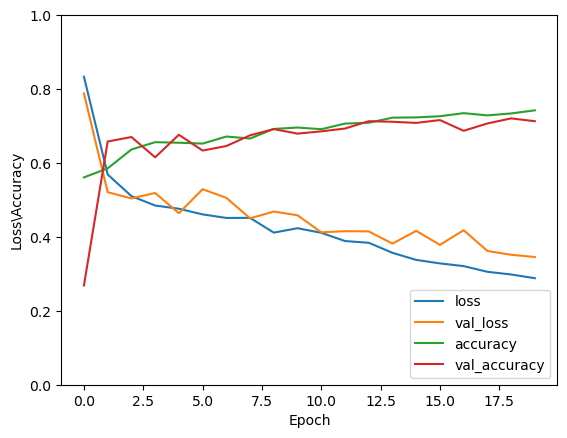

In [9]:
# Plot the loss and accuracy of the model
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss\Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [30]:
# Evaluate the model on the testing dataset
# This is the final accuracy of the model
test_loss, test_acc = model.evaluate(testing_dataset, verbose=2)
print("Testing Data Accuracy: ", end="")
print(test_acc * 100)
print("Testing Data Loss: ", end="")
print(test_loss)

21/21 - 2s - loss: 0.3996 - accuracy: 0.6901 - 2s/epoch - 91ms/step
Testing Data Accuracy: 69.00763511657715
Testing Data Loss: 0.3995838463306427


The f1 score is [tbd]

In [49]:
# Calculate the F1 Score of the model

# Not working atm

predictions = model.predict(testing_dataset)
mlb = MultiLabelBinarizer()
predictions_binary = (predictions > 0.5).astype(int)

y_true = mlb.fit_transform(testing_labels.astype(str))
y_pred = mlb.fit_transform(predictions_binary.astype(str))

print(len(y_true))
print(len(y_pred))

precision, recall,  = f1_score(y_true, y_pred, average='weighted')

print(f'F1 Score: {f1}')


21/21 [==============================] - 2s 82ms/step
655
655


ValueError: Multi-label binary indicator input with different numbers of labels